### First we will read in data as images.

Train Population Size: 600
Test Population Size: 100


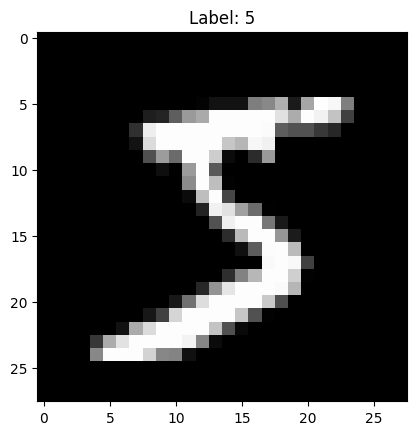

<class 'numpy.ndarray'>
(1, 28, 28)
Class: 1


In [35]:
# The following line was necessary to import the MNIST images.
# Source: https://stackoverflow.com/questions/78668638/unable-to-load-mnist-data-set-due-to-ssl-error-in-keras-load-data-function
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

# Libraries to include data and reading it in as images and arrays
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

# Load MNIST dataset as images
train_dataset_as_images = dsets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset_as_images = dsets.MNIST(root='./data', train=False, download=True, transform=None)

# Load the MNIST dataset as arrays
train_dataset_as_arrays = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset_as_arrays = [(t.numpy(), c) for t,c in train_dataset_as_arrays]
test_dataset_as_arrays = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_dataset_as_arrays = [(t.numpy(), c) for t,c in test_dataset_as_arrays]

# The population is way too big for this notebook to handle in a reasonable amount of time - we'll scale down
train_indices = range(len(train_dataset_as_arrays))
train_sample_indices = random.sample(population=train_indices, k=int(0.01*len(train_indices)))
test_indicies = range(len(test_dataset_as_arrays))
test_sample_indices = random.sample(population=test_indicies, k=int(0.01*len(test_indicies)))
train_dataset_as_arrays = [train_dataset_as_arrays[i] for i in train_sample_indices]
test_dataset_as_arrays = [test_dataset_as_arrays[i] for i in test_sample_indices]
print(f"Train Population Size: {len(train_dataset_as_arrays)}")
print(f"Test Population Size: {len(test_dataset_as_arrays)}")

# Display the first sample image
first_image, first_label = train_dataset_as_images[0]
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {first_label}")
plt.show()

# Display said image as an array
first_image_array, first_label = train_dataset_as_arrays[0]
print(type(first_image_array))
print(first_image_array.shape)
print(f"Class: {first_label}")

### We need to create a neural network - at heart a list of matrices.

In [ ]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt

class ANN:
    
    def __init__(self, input_dim: int, layer_dims: list[int], initialization_constant: int=1, lr: float=0.01):
        """Create an artificial neural network which is defined by the number of layers and the number of neurons per layer

        Args:
            layer_dims (list[int]): number of neurons per each respective layer
            num_classifications (int): number of different classes each input could belong to (i.e. for handwritten digits, this will be 10 --> representing 0-9)
            initialization_constant (int, optional): upper bound for maximum value of randomly initialized weights. Defaults to 1.
            lr (float, optional): scalar used when performing gradient descent. Defaults to 0.01.
        """
        self.__weight_matrices = [-initialization_constant + 2*initialization_constant*np.random.randn(input_dim, layer_dims[0])] + [-initialization_constant + 2*initialization_constant*np.random.randn(prev_dim, next_dim) for prev_dim, next_dim in zip(layer_dims, layer_dims[1:])]
        self.__binary = layer_dims[-1] == 1
        self.__learning_rate = lr
    
    def __merge_network_elements(self, weights: list[np.ndarray], linear_outputs: list[np.ndarray], activation_outputs: list[np.ndarray]):
        """Helper method to merge the network elements - including weight matrices, linear output vectors, and activation output vectors into one list

        Args:
            weights (list[np.ndarray]): weight matrices
            linear_outputs (list[np.ndarray]): linear output vectors
            activation_outputs (list[np.ndarray]): activation output vectors
        """
        # Merge into a list of [W0, z0, a0, W1, z1, a1, W2, z2, a2, etc...]
        i = 0
        network_components = [weights, linear_outputs, activation_outputs]
        self.__network_elements = []
        self.__weight_matrices = []
        while any(network_components):
            if network_components[i]:
                next = network_components[i].pop(0)
                if i == 0:
                    self.__weight_matrices.append(next)
                self.__network_elements.append(next)
            i = (i + 1) % 3
        self.__derivatives = [None for _ in self.__network_elements]
        # dL/dW_0, dL/dz_0, dL/da_0, dL/dW_1, dL/dz_1, dL/da_1, ..., etc.
    
    def __sigmoid(x: float) -> float:
        return 1 / (1 + exp(-x))

    __vector_sigmoid_func = np.frompyfunc(__sigmoid, 1, 1)
    
    def __sigmoid(vector: np.ndarray) -> np.ndarray:
        """Helper function to apply the sigmoid activation function to a numpy array

        Args:
            vector (np.ndarray): vector to apply sigmoid on (element-wise)

        Returns:
            np.ndarray: resulting vector from sigmoid function
        """
        return ANN.__vector_sigmoid_func(vector)

    def __forward(self, input: np.ndarray, train: bool=True) -> np.ndarray:
        """Forward propagation for this neural network

        Args:
            input (np.ndarray): input vector to predict classification for

        Returns:
            np.ndarray: output vector to represent the prediction for the input vector
        """
        x = input
        weights = []
        if train:
            linear_outputs = []
            activation_outputs = []
            for W in self.__weight_matrices:
                weights.append(W)
                x = np.matmul(x, W)
                linear_outputs.append(x)
                x = ANN.__sigmoid(x)
                activation_outputs.append(x)
            self.__merge_network_elements(weights=weights, linear_outputs=linear_outputs, activation_outputs=activation_outputs)
        else:
            for W in self.__weight_matrices:
                x = np.matmul(x, W)
                x = ANN.__sigmoid(x)
        return x
    
    def get_prediction(self, input: np.ndarray) -> int:
        """Public helper method to get a quick prediction for a vector

        Args:
            input (np.ndarray): input vector whose classification we can predict

        Returns:
            int: network's prediction for said input
        """
        x = input
        for W in self.__weight_matrices:
            x = np.matmul(x, W)
            x = ANN.__sigmoid(x)
        return np.argmax(x) if not self.__binary else np.round(x[0][0])

    def __calculate_gradients(self, last_input: np.ndarray, last_output: np.ndarray, target_output: np.ndarray):
        """Given the numerical loss received from a training observation, calculate the gradient of the loss and update each weight accordingly

        Args:
            last_output (np.ndarray): predicted output for the last input vector
            target_output (np.ndarray): expected output for the last input vector (something like [0, 0, 0, 0, 1, 1, 1])
        """
        # We know the immediate gradient for the last layer
        if not self.__binary:
            self.__derivatives[-1] = 2 * (last_output - target_output) # vector
        else:
            # TODO - cross entropy loss derivative
            self.__derivatives[-1] = 0
        for i in range(len(self.__derivatives)-2, -1, -1):
            if i % 3 == 0:
                # weight matrix derivative
                activation_output_layer = self.__network_elements[i-1] if i > 0 else last_input
                # dL/dW_i_k_j = dL/dz_i_k * dz_i_k/dW_i_k_j = dL/dz_i_k * a_{i-1}_j
                # dL/dW_i_k = dL/dz_i_k(a_{i-1})
                # dL/dW_i = (dL/dz_i) X (a_{i-1})
                dz_i_transpose = self.__derivatives[i+1].T
                self.__derivatives[i] = np.matmul(dz_i_transpose, activation_output_layer)
            elif i % 3 == 1:
                # linear output layer derivative
                activation_output_layer = self.__network_elements[i+1]
                # dL/dz_i = dL/da_i * da_i/dz_i = dL/da_i * a_i * (1-a_i) since the derivative of sigmoid at x is sigmoid(x)(1-sigmoid(x))
                self.__derivatives[i] = self.__derivatives[i+1] * activation_output_layer * (np.ones(shape=activation_output_layer.shape) - activation_output_layer)
            else:
                # activation layer derivative
                next_weight_matrix = self.__network_elements[i+1]
                # dL/da_i = (dL/dz_{i+1}) X (dz_{i+1}/da_i) = (dL/dz_{i+1}) X (W_{i+1}.T)
                dz_next = self.__derivatives[i+2] 
                self.__derivatives[i] = np.matmul(dz_next, next_weight_matrix.T)
        
    def __update_weights(self):
        """Helper method to update the weights of our neural network
        """
        for i in range(0, len(self.__derivatives)-2, 3):
            self.__weight_matrices[i // 3] = self.__weight_matrices[i // 3] - self.__learning_rate * self.__derivatives[i].T
            
    def __perform_SGD(self, train_set: list[np.ndarray], expected_outputs: list[np.ndarray]) -> tuple[float,float]:
        """Given a batch of observations, calculate the average gradient and update all weights accordingly, returning the loss and accuracy of the network on this batch

       Args:
            train_set (list[np.ndarray]): input feature vectors
            expected_outputs (list[np.ndarray]): expected outputs for each input vector

        Returns:
            tuple[float,float]: loss and accuracy
        """
        average_loss = 0
        average_accuracy = 0
        for input, expected_output in zip(train_set, expected_outputs):
            output = self.__forward(input=input)
            self.__calculate_gradients(last_input=input, last_output=output, target_output=expected_output)
            self.__update_weights()
            if not self.__binary:
                average_loss += (1 / len(train_set)) * np.sum(np.square(output - expected_output))
            else:
                # TODO - cross entropy loss
                pass
            predicted_class = self.get_prediction(input)
            actual_class = np.argmax(expected_output) if not self.__binary else np.round(expected_output[0][0])
            if predicted_class == actual_class:
                average_accuracy += 1 / len(train_set)
        return (average_loss, average_accuracy)
    
    def __get_test_accuracy(self, test_set: list[np.ndarray], expected_outputs: list[np.ndarray]) -> float:
        """Calculate the testing accuracy for the list of observations which have not been used to train this network

        Args:
            test_set (list[np.ndarray]): set of observations which have not been used to train the network
            expected_outputs (list[np.ndarray]): expected output results for each test observation

        Returns:
            float: accuracy of this network on the testing population
        """
        average_accuracy = 0
        for input, expected_output in zip(test_set, expected_outputs):
            predicted_class = self.get_prediction(input)
            actual_class = np.argmax(expected_output) if not self.__binary else np.round(expected_output[0][0])
            if predicted_class == actual_class:
                average_accuracy += 1 / len(test_set)
        return average_accuracy
    
    def train_and_test(self, train_set: list[np.ndarray], expected_train_results: list[np.ndarray], test_set: list[np.ndarray], expected_test_results: list[np.ndarray], num_epochs: int=100):
        """Train the  network on the training observations, and test their results on the test populations

        Args:
            train_set (list[np.ndarray]): training population
            expected_train_results (list[np.ndarray]): training population expected results
            test_set (list[np.ndarray]): testing population
            expected_test_results (list[np.ndarray]): testing population results
            num_empochs (int, optional): number of times the network trains through the entire epoch. Defaults to 100.
        """
        training_loss_by_epoch = []
        training_accuracy_by_epoch = []
        testing_accuracy_by_epoch = []
        for i in range(num_epochs):
            train_loss, train_accuracy = self.__perform_SGD(train_set=train_set, expected_outputs=expected_train_results)
            training_loss_by_epoch.append(train_loss)
            training_accuracy_by_epoch.append(train_accuracy)
            test_accuracy = self.__get_test_accuracy(test_set=test_set, expected_outputs=expected_test_results)
            testing_accuracy_by_epoch.append(test_accuracy)
            if i % (num_epochs // 10) == 0:
                print(f"{i/num_epochs * 100}% through training...")
        
        # Plot training loss
        plt.plot(range(num_epochs), training_loss_by_epoch, 'rx')
        plt.title("Training Loss by Epoch")
        plt.xlabel("Epoch Number")
        plt.ylabel("Training Loss")
        plt.show()
        
        # Plot training accuracy
        plt.plot(range(num_epochs), training_accuracy_by_epoch, 'go')
        plt.title("Training Accuracy by Epoch")
        plt.xlabel("Epoch Number")
        plt.ylabel("Training Accuracy")
        plt.show()
        
        # Plot testing accuracy
        plt.plot(range(num_epochs), testing_accuracy_by_epoch, 'go')
        plt.title("Testing Accuracy by Epoch")
        plt.xlabel("Epoch Number")
        plt.ylabel("Testing Accuracy")
        plt.show()

In [37]:
# Now let us create an ANN and train it on the MNIST images...
neural_network = ANN(input_dim=28*28, layer_dims=[28*14, 28*7, 28*3, 28, 14, 10])

In [38]:
# Load training input vectors
train_vectors = [array_class_pair[0].reshape(1,28*28) for array_class_pair in train_dataset_as_arrays]
# Create expected output vector results
def make_output_array(classification: int) -> np.ndarray:
    x = np.zeros(shape=(1,10))
    x[0][classification] = 1.0
    return x
expected_train_outputs = [make_output_array(classification=array_class_pair[1]) for array_class_pair in train_dataset_as_arrays]

# Now do the same for the test population
test_vectors = [array_class_pair[0].reshape(1,28*28) for array_class_pair in test_dataset_as_arrays]
expected_test_outputs = [make_output_array(classification=array_class_pair[1]) for array_class_pair in test_dataset_as_arrays]

In [39]:
neural_network.train_and_test(train_set=train_vectors, expected_train_results=expected_train_outputs, test_set=test_vectors, expected_test_results=expected_test_outputs)

0.0% through training...


KeyboardInterrupt: 

### That performance was pretty bad, but maybe if we step down to some lower dimensional data it could improve!

In [63]:
class FileVectorReader:
    """This class takes in data as a pandas data frame along with a block size and parameter for the k nearest neighbors, 
    """
    
    def __init__(self, file_name: str, delimiter: str, id_column_name: str, classification_column_name: str, lr: float=0.01):
        """Initialize a FileVectorReader, which creates a list of vectors - each an observation given from the given file
        Args:
            file_name (str): The file from which to read in data
            k (int): The number of closest other points used to guess if a certain point belongs to a given classification
            n (int): The number of different blocks to partition the training points into
        """
        # First let's read in our data
        read_from = open(file_name, "r")
        points_as_strings = read_from.readlines()

        # Let's look at the first line, which reveals the point attributes which are numeric
        header = points_as_strings[0][:-1] # Remember to omit the '\n' character
        attributes = header.split(delimiter)
        class_idx = -1
        id_idx = -1
        attribute_name_indices = []
        # For each attribute, store its value for all observations
        attribute_values = {}
        for i, attr in enumerate(attributes):
            if attr == classification_column_name:
                class_idx = i
            elif attr == id_column_name:
                id_idx = i
            else:
                attribute_name_indices.append(i)
                attribute_values[i] = []
        points_as_strings = points_as_strings[1:]
        read_from.close()
        
        unique_labels = set()
        labels = []
        names = []
        for point_string in points_as_strings:
            # First omit the '\n' character in each row of data corresponding to a point
            # Get a list of strings, each corresponding to an attribute of the point
            point_attributes = point_string[:-1].split(delimiter)

            # Record the unique name and class of this point, and keep track of all the different classes we have seen
            labels.append(int(point_attributes[class_idx]))
            unique_labels.add(int(point_attributes[class_idx]))
            names.append(point_attributes[id_idx])

            # Record all attribute elements of the points 
            for idx in attribute_name_indices:
                attribute_values[idx].append(point_attributes[idx])
                
        # We need to look through each of the attribute value sets, and see which are continuous
        # The first value will do:
        #   If it is an integer, assume discrete unless we are corrected
        #   If it is a float, assume continuous
        #   If it is a string, assume discrete
        numerical_attribute_indices = set() # Column indices of all numerical attributes
        discrete_named_attribute_indices = set() # Column indices of all discrete named attributes
        for idx, values in attribute_values.items():
            for i, string in enumerate(values):
                try:
                    # Is a float
                    float(string)
                    numerical_attribute_indices.add(idx)
                except:
                    # Not a float
                    discrete_named_attribute_indices.add(idx)
        
        # We will do something similar for the continuous attribute, but we need to discretize...
        numerical_attribute_values = {} # List for all observations in the file
        for attr_idx in numerical_attribute_indices:
            numerical_attribute_values[attr_idx] = []
            for point_string in points_as_strings:
                point_attributes = point_string[:-1].split(delimiter)
                numerical_attribute_values[attr_idx].append(float(point_attributes[attr_idx]))
        # Normalize a vector
        def normalize(x: list[float]):
            """Helper method to normalize a vector (treated as a list)

            Args:
                x (list[float]): vector to normalize - putting all values between 0 and 1
            """
            u = max(x)
            l = min(x)
            for idx, v in enumerate(x):
                x[idx] = (v - l) / (u - l)
        # Use those functions to discretize
        for attr_idx in numerical_attribute_values.keys():
            normalize(numerical_attribute_values[attr_idx])
            
        # Next we will handle the attributes which have string values - which are therefore discrete attributes
        discrete_named_attribute_values = {} # dict[int, list[string]], but will SOON become dict[int, list[int]] via the next variable...
        possible_discrete_named_attribute_values = {} # dict[int, dict[string, int]]
        for attr_idx in discrete_named_attribute_indices:
            discrete_named_attribute_values[attr_idx] = []
            possible_discrete_named_attribute_values[attr_idx] = {}
            for point_string in points_as_strings:
                point_attributes = point_string[:-1].split(delimiter)
                str_value = point_attributes[attr_idx]
                discrete_named_attribute_values[attr_idx].append(str_value)
                # map that string to an integer
                possible_discrete_named_attribute_values[attr_idx][str_value] = len(possible_discrete_named_attribute_values[attr_idx])
        # Now turn the named discrete attributes into integers
        for attr_idx, names in discrete_named_attribute_values.items():
            for idx, name in enumerate(names):
                # Map this name to a number
                discrete_named_attribute_values[attr_idx][idx] = possible_discrete_named_attribute_values[attr_idx][name]
                    
        # Now we can create our list of attributes, and all possible values for said attributes
        #   numerical_attribute_values - dict[int, list[float]]
        #   discrete_named_attribute_values - dict[int, list[int]]
        # Combine those three dictionaries into one dictionary
        attribute_values = {} # Values of each attribute for all observations (mapped by column index)
        possible_attribute_values = {} # All possible values of each attribute (mapped by column index)
        for attr_idx, values in numerical_attribute_values.items():
            attribute_values[attr_idx] = values
            possible_attribute_values[attr_idx] = set(values)
        for attr_idx, values in discrete_named_attribute_values.items():
            attribute_values[attr_idx] = values
            possible_attribute_values[attr_idx] = set(values)
        # attribute_values - dict[int, list[int]]
        # possible_attribute_values - dict[int, set[int]]

        # Now we are ready to create a list of vectors
        self.__vectors = []
        for idx in range(len(points_as_strings)):
            vector_values = [float(attribute_values[col][idx]) for col in attribute_values.keys()]
            self.__vectors.append(np.array([vector_values]))
        
        # Break up data into training and testing...
        n = len(self.__vectors)
        train_size = (n * 8) // 10
        training_indices = set(random.sample(population=range(n), k=train_size))
        test_indices = set([i for i in range(n) if i not in training_indices])
        self.__train_population = [self.__vectors[i] for i in training_indices]
        self.__train_labels = [labels[i] for i in training_indices]
        self.__test_population = [self.__vectors[i] for i in test_indices]
        self.__test_labels = [labels[i] for i in test_indices]
        
        # Turn the classifications into vectors
        self.__binary = len(unique_labels) == 2
        self.__train_classifications = [np.zeros(shape=(1, len(unique_labels) if not self.__binary else 1)) for _ in self.__train_population]
        for i in range(len(self.__train_labels)):
            if not self.__binary:
                self.__train_classifications[i][0][self.__train_labels[i]] = 1.0
            else:
                self.__train_classifications[i][0][0] = float(self.__train_labels[i])
        self.__test_classifications = [np.zeros(shape=(1, len(unique_labels) if not self.__binary else 1)) for _ in self.__test_population]
        for i in range(len(self.__test_labels)):
            if not self.__binary:
                self.__test_classifications[i][0][self.__test_labels[i]] = 1.0
            else:
                self.__test_classifications[i][0][0] = float(self.__test_labels[i])
        
        # Make a neural network
        layer_dims = []
        size = len(attribute_values)
        end_size = len(unique_labels)
        while size > end_size:
            layer_dims.append(size)
            size //= 2
        if end_size == 2:
            layer_dims.append(1)
        else:
            layer_dims.append(end_size)
        self.__neural_network = ANN(input_dim=len(attribute_values), layer_dims=layer_dims, lr=lr)
              
    def display_results(self):
        """Helper method to display the underlying decision neural network's performance
        """
        self.__neural_network.train_and_test(train_set=self.__train_population, expected_train_results=self.__train_classifications, test_set=self.__test_population, expected_test_results=self.__test_classifications)     
            
    def plot_predictions(self):
        # If we do not have two-dimensional data, do not plot
        if len(self.__vectors) < 1 or self.__vectors[0].shape[1] != 2:
            return
        
        # Plot our data with its actual classifications
        self.__plot_data(population=self.__train_population, classifications=self.__train_labels, training_or_testing="Training")
        self.__plot_data(population=self.__test_population, classifications=self.__test_labels, training_or_testing="Testing")
        
        # Plot our predictions
        self.__plot_predictions(population=self.__train_population, training_or_testing="Training")
        self.__plot_predictions(population=self.__test_population, training_or_testing="Testing")
        
    def __plot_data(self, population: list[np.ndarray], classifications: list[int], training_or_testing: str):
        """Helper method to plot a list of observations

        Args:
            population (list[Observation]): the list of observations to plot - each of which had better have two attributes or this method should not have been called
        """
        fig, ax = plt.subplots()
        X = [vector[0][0] for vector in population]
        Y = [vector[0][1] for vector in population]
        scatter = ax.scatter(X, Y, c=classifications)
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend)
        plt.title(f"Actual {training_or_testing} Data:")
        plt.xlabel("Attribute 1 Value")
        plt.ylabel("Attribute 2 Value")
        plt.show()
        fig.clear()
        
    def __plot_predictions(self, population: list[np.ndarray], training_or_testing: str):
        """Helper method to plot the predictions of a population

        Args:
            population (list[Observation]): list of observations we want to predict
        """
        fig, ax = plt.subplots()
        X = [vector[0][0] for vector in population]
        Y = [vector[0][1] for vector in population]
        classifications = [self.__neural_network.get_prediction(input=vector) for vector in population]
        scatter = ax.scatter(X, Y, c=classifications)
        # Produce a legend with the unique colors from the scatter
        # Source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
        legend = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend)
        plt.title(f"Model Prediction for {training_or_testing} Data:")
        plt.xlabel("Attribute 1 Value")
        plt.ylabel("Attribute 2 Value")
        plt.show()
        fig.clear()

0.0% through training...
10.0% through training...
20.0% through training...
30.0% through training...
40.0% through training...
50.0% through training...
60.0% through training...
70.0% through training...
80.0% through training...
90.0% through training...


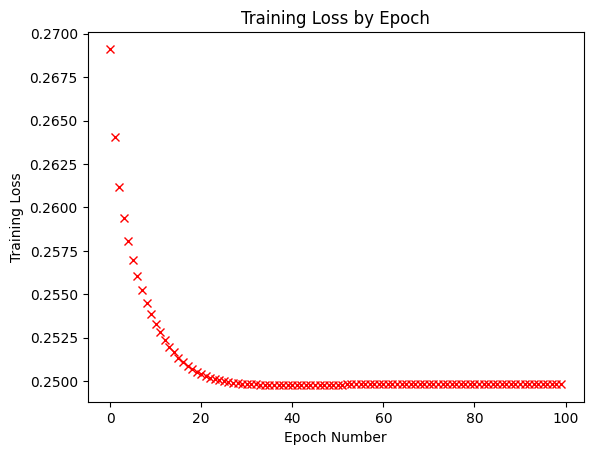

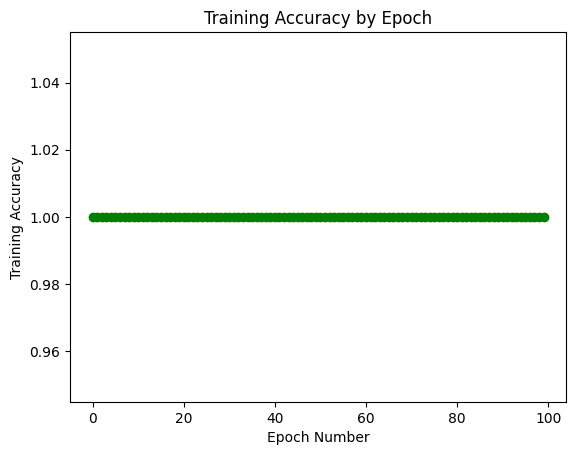

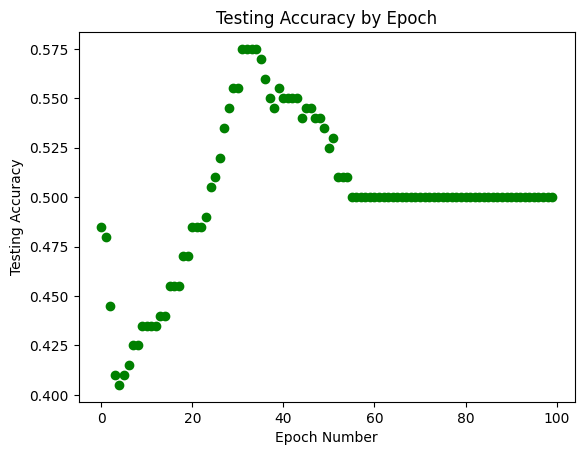

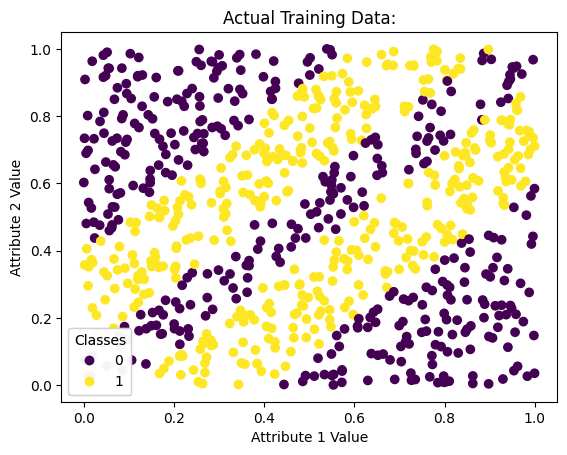

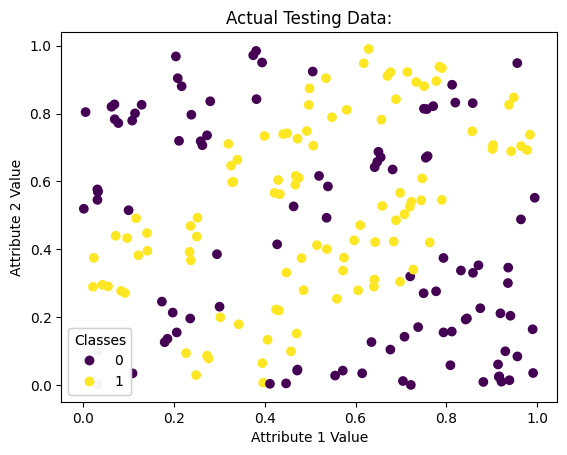

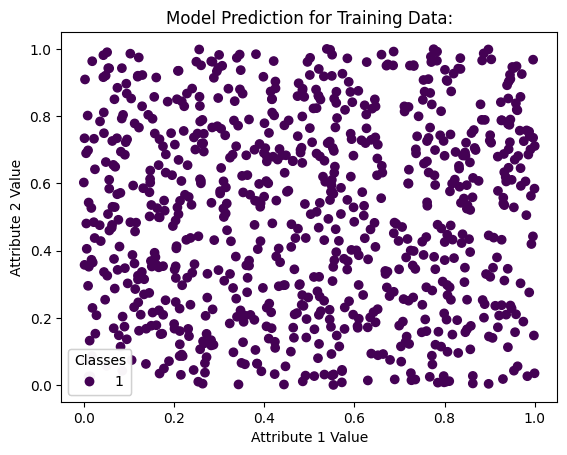

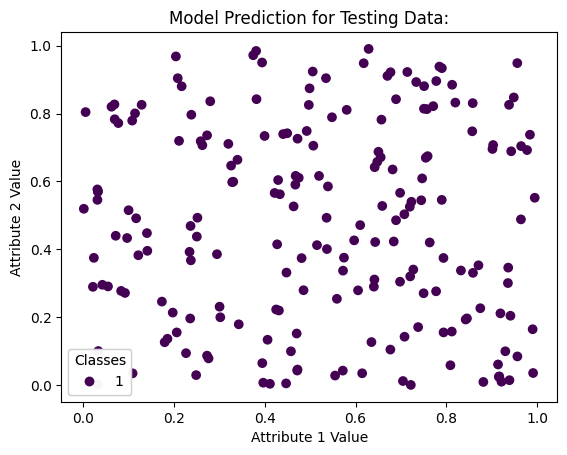

In [64]:
fvr = FileVectorReader(file_name="labeled-examples", delimiter=" ", id_column_name="id", classification_column_name="class", lr=0.01)
fvr.display_results()
fvr.plot_predictions()

0.0% through training...
10.0% through training...
20.0% through training...
30.0% through training...
40.0% through training...
50.0% through training...
60.0% through training...
70.0% through training...
80.0% through training...
90.0% through training...


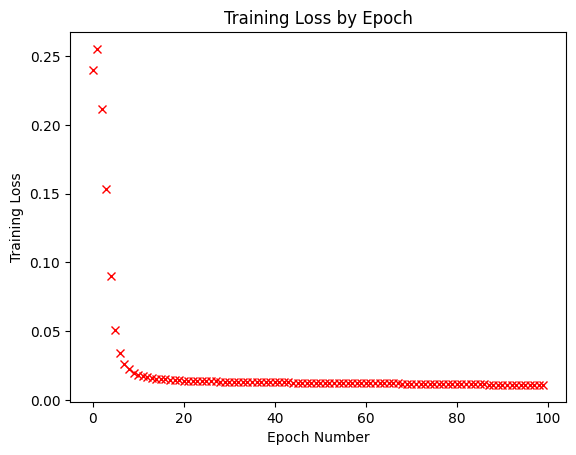

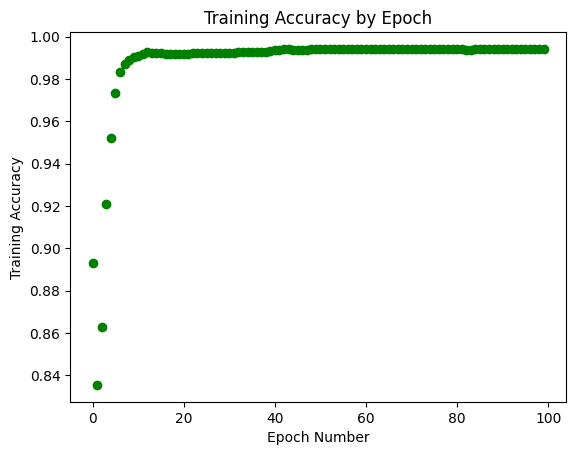

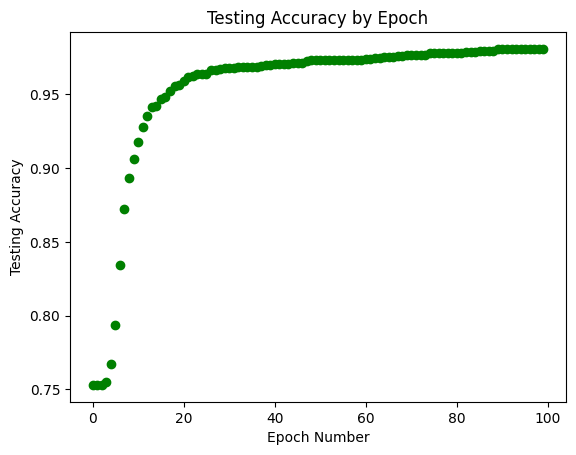

In [59]:
fvr = FileVectorReader(file_name="winequality.csv", delimiter=";", id_column_name="\"id\"", classification_column_name="\"type\"")
fvr.display_results()